In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import sqrt
import os


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = '/kaggle/input/seoul-bike-rental-ai-pro-iti/'
data = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

In [3]:
# Rename columns 
data = data.rename(columns={'Temperature(�C)': 'Temp', 'Dew point temperature(�C)': 'dew_pt_temp'})

In [4]:
data['Date']= pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop(columns=['Date'])

In [5]:
# Create translation tables for day, season, holiday, funcationing day

data['Seasons']=np.where(data['Seasons'] == 'Spring', 1, data['Seasons'])
data['Seasons']=np.where(data['Seasons'] == 'Summer', 2, data['Seasons'])
data['Seasons']=np.where(data['Seasons'] == 'Autumn', 3, data['Seasons'])
data['Seasons']=np.where(data['Seasons'] == 'Winter', 4, data['Seasons'])
data['Holiday']=np.where(data['Holiday'] == 'No Holiday', 0, data['Holiday'])
data['Holiday']=np.where(data['Holiday'] == 'Holiday', 1, data['Holiday'])
data['Functioning Day']=np.where(data['Functioning Day'] == 'No', 0, data['Functioning Day'])
data['Functioning Day']=np.where(data['Functioning Day'] == 'Yes', 1, data['Functioning Day'])

In [6]:
# Update data types to numeric. 
cols = ['Day','Seasons','Holiday','Functioning Day']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce', axis=1) 

In [7]:
# Correlation coefficient matrix
corrMat = data.corr()
corrMat

,ID,y,Hour,Temp,Humidity(%),Wind speed (m/s),Visibility (10m),dew_pt_temp,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,year,Month,Day
ID,1.000000,0.365359,4.163048e-03,0.641690,0.199314,-0.169976,0.059272,0.628503,0.113897,0.039103,-0.207435,-1.936492e-01,-4.243601e-02,-0.211017,4.787136e-01,2.445311e-01,2.580728e-01
y,0.365359,1.000000,4.071798e-01,0.544281,-0.191603,0.116380,0.214777,0.392454,0.250601,-0.117711,-0.120836,-2.569560e-01,-5.832858e-02,0.227269,2.018374e-01,7.349847e-02,1.019814e-01
Hour,0.004163,0.407180,1.000000e+00,0.126636,-0.265750,0.289310,0.101892,-0.000374,0.146439,-0.010498,-0.013013,2.233894e-16,-5.481140e-17,0.007366,4.561664e-15,4.283714e-16,3.937296e-16
Temp,0.641690,0.544281,1.266364e-01,1.000000,0.172183,-0.038550,0.041475,0.916921,0.348782,0.049559,-0.184699,-5.150311e-01,-4.568134e-02,-0.052875,4.003186e-01,4.028679e-03,1.631625e-01
Humidity(%),0.199314,-0.191603,-2.657503e-01,0.172183,1.000000,-0.350555,-0.545016,0.542925,-0.470457,0.231750,0.077986,-2.077379e-01,-8.438425e-02,-0.033030,7.610778e-02,-9.696700e-03,1.583677e-02
Wind speed (m/s),-0.169976,0.116380,2.893105e-01,-0.038550,-0.350555,1.000000,0.174755,-0.177511,0.338195,-0.020256,-0.019836,-9.025233e-03,3.880514e-02,0.003896,-1.294896e-02,-4.144105e-02,-1.362034e-01
Visibility (10m),0.059272,0.214777,1.018916e-01,0.041475,-0.545016,0.174755,1.000000,-0.165620,0.161345,-0.161302,-0.099078,1.216127e-01,4.686455e-02,0.013770,-7.398984e-03,9.172633e-02,-7.263641e-02
dew_pt_temp,0.628503,0.392454,-3.742059e-04,0.916921,0.542925,-0.177511,-0.165620,1.000000,0.094677,0.121263,-0.131155,-5.094992e-01,-7.442181e-02,-0.059014,3.692559e-01,6.739036e-03,1.436290e-01
Solar Radiation (MJ/m2),0.113897,0.250601,1.464389e-01,0.348782,-0.470457,0.338195,0.161345,0.094677,1.000000,-0.071560,-0.067684,-1.586131e-01,1.581284e-02,-0.011168,1.250754e-01,-5.246501e-03,5.575845e-03
Rainfall(mm),0.039103,-0.117711,-1.049772e-02,0.049559,0.231750,-0.020256,-0.161302,0.121263,-0.071560,1.000000,-0.003345,-6.537099e-02,-2.337549e-02,-0.005440,3.023728e-02,-4.168223e-02,-8.390658e-03


array([[<AxesSubplot:title={'center':'y'}>]], dtype=object)

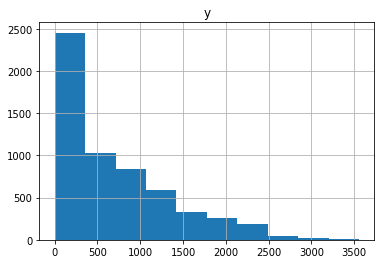

In [8]:
# Histogram of rented bike count 
data.hist('y')

In [9]:
features = ['Day','Hour', 'Temp', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'dew_pt_temp',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day','Month']
X = data[features].copy()

In [10]:
# define dependent variable
y = data['y']

In [11]:
# create the necessary training and testing data (75/25)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 123)

In [12]:
#Modeling (Regression)
algo = RandomForestRegressor()
model = algo.fit(X_train,y_train)

In [13]:
# Train Set Predictions
predictions_train = model.predict(X_train)
predRsquared = r2_score(y_train,predictions_train)
rmse = sqrt(mean_squared_error(y_train, predictions_train))
print('R Squared: %.3f' % predRsquared)
print('RMSE: %.3f' % rmse)

R Squared: 0.984
RMSE: 83.093


### Working On Test File

In [14]:
df_test = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

In [15]:
# Rename columns 
df_test = df_test.rename(columns={'Temperature(�C)': 'Temp', 'Dew point temperature(�C)': 'dew_pt_temp'})

In [16]:
df_test['Date']= pd.to_datetime(df_test['Date'])
df_test['year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month
df_test['Day'] = df_test['Date'].dt.day
df_test = df_test.drop(columns=['Date'])

In [17]:
# Create translation tables for day, season, holiday, funcationing day

df_test['Seasons']=np.where(df_test['Seasons'] == 'Spring', 1, df_test['Seasons'])
df_test['Seasons']=np.where(df_test['Seasons'] == 'Summer', 2, df_test['Seasons'])
df_test['Seasons']=np.where(df_test['Seasons'] == 'Autumn', 3, df_test['Seasons'])
df_test['Seasons']=np.where(df_test['Seasons'] == 'Winter', 4, df_test['Seasons'])
df_test['Holiday']=np.where(df_test['Holiday'] == 'No Holiday', 0, df_test['Holiday'])
df_test['Holiday']=np.where(df_test['Holiday'] == 'Holiday', 1, df_test['Holiday'])
df_test['Functioning Day']=np.where(df_test['Functioning Day'] == 'No', 0, df_test['Functioning Day'])
df_test['Functioning Day']=np.where(df_test['Functioning Day'] == 'Yes', 1, df_test['Functioning Day'])

In [18]:
# Update data types to numeric. 
cols = ['Day','Seasons','Holiday','Functioning Day']
df_test[cols] = df_test[cols].apply(pd.to_numeric, errors='coerce', axis=1) 

In [19]:
# Correlation coefficient matrix
corrMat = data.corr()
corrMat

,ID,y,Hour,Temp,Humidity(%),Wind speed (m/s),Visibility (10m),dew_pt_temp,Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,year,Month,Day
ID,1.000000,0.365359,4.163048e-03,0.641690,0.199314,-0.169976,0.059272,0.628503,0.113897,0.039103,-0.207435,-1.936492e-01,-4.243601e-02,-0.211017,4.787136e-01,2.445311e-01,2.580728e-01
y,0.365359,1.000000,4.071798e-01,0.544281,-0.191603,0.116380,0.214777,0.392454,0.250601,-0.117711,-0.120836,-2.569560e-01,-5.832858e-02,0.227269,2.018374e-01,7.349847e-02,1.019814e-01
Hour,0.004163,0.407180,1.000000e+00,0.126636,-0.265750,0.289310,0.101892,-0.000374,0.146439,-0.010498,-0.013013,2.233894e-16,-5.481140e-17,0.007366,4.561664e-15,4.283714e-16,3.937296e-16
Temp,0.641690,0.544281,1.266364e-01,1.000000,0.172183,-0.038550,0.041475,0.916921,0.348782,0.049559,-0.184699,-5.150311e-01,-4.568134e-02,-0.052875,4.003186e-01,4.028679e-03,1.631625e-01
Humidity(%),0.199314,-0.191603,-2.657503e-01,0.172183,1.000000,-0.350555,-0.545016,0.542925,-0.470457,0.231750,0.077986,-2.077379e-01,-8.438425e-02,-0.033030,7.610778e-02,-9.696700e-03,1.583677e-02
Wind speed (m/s),-0.169976,0.116380,2.893105e-01,-0.038550,-0.350555,1.000000,0.174755,-0.177511,0.338195,-0.020256,-0.019836,-9.025233e-03,3.880514e-02,0.003896,-1.294896e-02,-4.144105e-02,-1.362034e-01
Visibility (10m),0.059272,0.214777,1.018916e-01,0.041475,-0.545016,0.174755,1.000000,-0.165620,0.161345,-0.161302,-0.099078,1.216127e-01,4.686455e-02,0.013770,-7.398984e-03,9.172633e-02,-7.263641e-02
dew_pt_temp,0.628503,0.392454,-3.742059e-04,0.916921,0.542925,-0.177511,-0.165620,1.000000,0.094677,0.121263,-0.131155,-5.094992e-01,-7.442181e-02,-0.059014,3.692559e-01,6.739036e-03,1.436290e-01
Solar Radiation (MJ/m2),0.113897,0.250601,1.464389e-01,0.348782,-0.470457,0.338195,0.161345,0.094677,1.000000,-0.071560,-0.067684,-1.586131e-01,1.581284e-02,-0.011168,1.250754e-01,-5.246501e-03,5.575845e-03
Rainfall(mm),0.039103,-0.117711,-1.049772e-02,0.049559,0.231750,-0.020256,-0.161302,0.121263,-0.071560,1.000000,-0.003345,-6.537099e-02,-2.337549e-02,-0.005440,3.023728e-02,-4.168223e-02,-8.390658e-03


In [20]:
features = ['Day','Hour', 'Temp', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'dew_pt_temp',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day','Month']
X_test = df_test[features].copy()

In [21]:
# Train Set Predictions
predictions = model.predict(X_test)

### Submission File

In [22]:
te = pd.DataFrame()
te['ID'] = df_test['ID']
te['y'] = predictions

In [23]:
te.to_csv('/kaggle/working/submission.csv', index=False)